In [149]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import community 
import pickle
import itertools
from upsetplot import from_contents, UpSet
import get_binarized_map_of_selected_loci_3 as diff
from mne_connectivity.viz import plot_connectivity_circle
from tqdm import tqdm
import time

import get_binarized_map_of_selected_loci_3 as diff

In [743]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_3' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_3.py'>

In [62]:
data_dir = '/home/braunger/masterthesis/data/'
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'

# 1. Binarized maps and difference matrix

In [560]:
young = pd.read_csv(hic_dir+'Young_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
old = pd.read_csv(hic_dir+'Old_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)

# Differences between young and old
diff_map = young + 2 * old
print(diff_map.shape)
diff_map.to_csv(hic_dir+'difference_maps/diff_all_gene_loci.csv')

(5399, 5399)


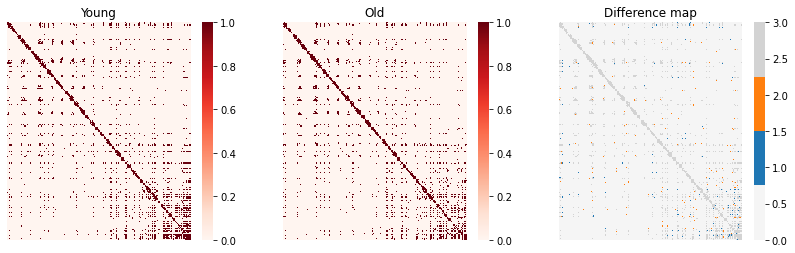

In [563]:
%matplotlib inline
diff.plot_binarized_maps(young, old, diff_map, filtering = False)

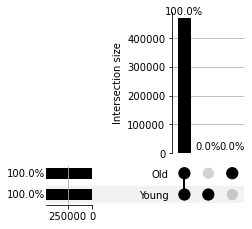

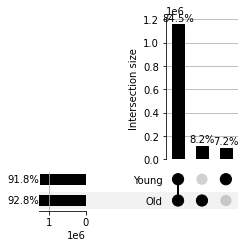

In [578]:
# How strongly do the interactions overlap
def get_intra(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] == df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

def get_inter(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] != df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

# UpSet plot for intrachromosomal contacts
intersections = from_contents({'Young': get_intra(young),
                               'Old': get_intra(old)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,  
              sort_by="cardinality").plot()

# UpSet plot for interchromosomal contacts
intersections = from_contents({'Young': get_inter(young),
                               'Old': get_inter(old)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,  
              sort_by="cardinality").plot()

# 2. Number of intermingling regions per chromosome pair

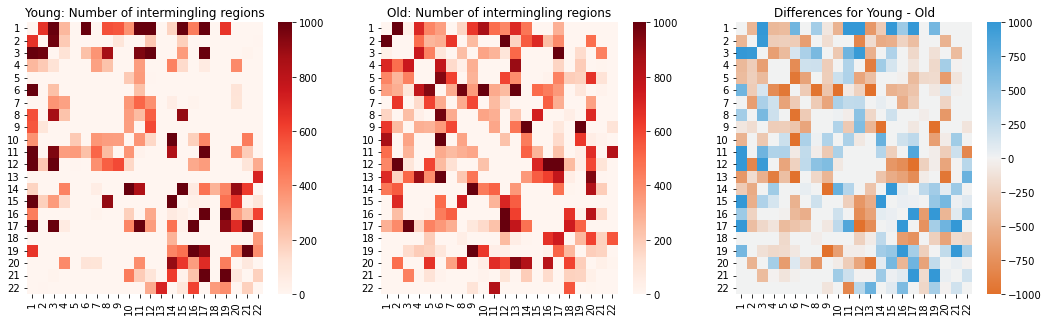

In [66]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
diff.plot_specific_intermingling(chr_list, diff_map, "Young", axs[0])
diff.plot_specific_intermingling(chr_list, diff_map, "Old", axs[1])
diff.plot_intermingling_diff(chr_list, diff_map, "Young", "Old", axs[2], -1000, 1000)
#plt.savefig(fig_dir + 'specific_intermingling_per_chr_pair.png')
plt.show()

# 3. DE targets of selected TFs
## a) First net TF

In [685]:
TF = 'RELA'
transition = 'fc_16-26_27-60'
#TF = 'CDK9'
#transition = 'fc_61-85_86-96'
#TF = 'DDX5'
#transition = 'fc_61-85_86-96'

# load DE genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]

# load DE targets of selected TF
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
print(TF_targets.shape)
TF_targets = TF_targets[['target', 'locus']]

# save order of the genes according the corresponding loci
locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]
TF_targets = TF_targets.set_index('locus', drop = False)
TF_targets = TF_targets.loc[locus_order, :]
gene_order = TF_targets['target']

# create diff_map for DE targets
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(TF_targets['locus']) & diff_map_long['loc2'].isin(TF_targets['locus'])]
diff_map_long = TF_targets.rename(columns={"target": "target1", "locus": "loc1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = TF_targets.rename(columns={"target": "target2", "locus": "loc2"}).merge(diff_map_long, on = 'loc2')
diff_map_long = diff_map_long[['target1', 'target2', 'value']]
TF_diff_map = diff_map_long.pivot_table(index='target1', columns='target2', values='value')

# sorting according to chromosomes
TF_diff_map = TF_diff_map.loc[gene_order, gene_order]
TF_diff_map.to_csv(save_dir + 'processed_hic_data/difference_maps/diff_DE_DDX5_old.csv', index = False)

(6, 8)


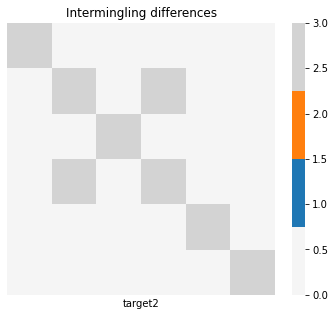

In [686]:
palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[0], palette[1], 'lightgrey']
cmap = ListedColormap(colors)

plt.figure(figsize = (6,5))
sns.heatmap(TF_diff_map, cmap = cmap, xticklabels=False, yticklabels=False)
plt.ylabel('') 
plt.title('Intermingling differences')
plt.show()

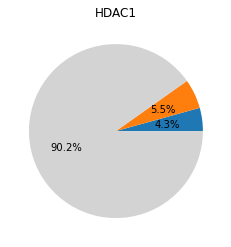

In [437]:
TF_diff_long = TF_diff_map.copy()
TF_diff_long['loc1'] = TF_diff_long.index
TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
TF_diff_long = TF_diff_long[TF_diff_long['value']!=0]
intermingling_percent = TF_diff_long.groupby('value')['value'].count()
plt.pie(intermingling_percent, autopct='%1.1f%%', colors = colors[1:])
plt.title(TF)
plt.show()

### Activity maps

In [438]:
# load activities of DE genes
activities = pd.read_csv(save_dir+'active_loci/gene_activity_hic.csv')
activities = activities[['gene_symbol', 'cell_state', 'activity']]
activities = activities[activities['gene_symbol'].isin(TF_diff_map.columns) & activities['cell_state'].isin(['young', 'old'])]

# add activities to diff map
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
act_intermingling = diff_map_long.merge(activities.rename(columns = {'gene_symbol': 'target1', 'activity': 'activity1'}))
act_intermingling = act_intermingling.merge(activities.rename(columns = {'gene_symbol': 'target2', 'activity': 'activity2'}))
act_intermingling['activity'] = act_intermingling['activity1'] + "_" + act_intermingling['activity2']
act_intermingling['activity'] = act_intermingling['activity'].replace(['active_active', 'active_inactive', 'inactive_active', 'inactive_inactive'], [1, 3, 3, 2])
act_intermingling.head()

,target1,target2,value,cell_state,activity1,activity2,activity
0,NIPAL3,NIPAL3,3.0,old,active,active,1
1,MAN1C1,NIPAL3,3.0,old,inactive,active,3
2,PLXNB1,NIPAL3,3.0,old,active,active,1
3,FLOT1,NIPAL3,3.0,old,active,active,1
4,TNXB,NIPAL3,3.0,old,inactive,active,3


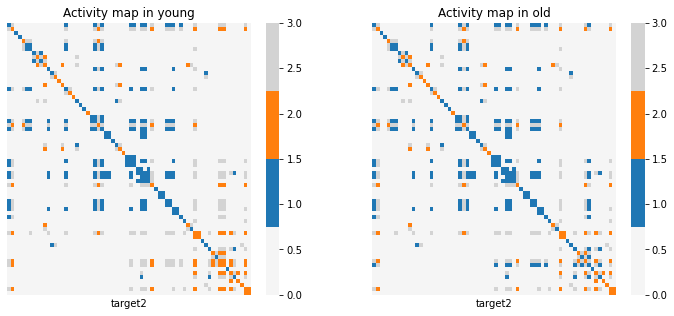

In [439]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

gene_order = [gene for gene in gene_order if gene in act_intermingling['target1'].unique()]
act_map_y = act_intermingling[act_intermingling['cell_state'] == 'young']
act_map_y = act_map_y.pivot_table(index='target1', columns='target2', values='activity').fillna(0)
act_map_y = act_map_y.loc[gene_order, gene_order]
sns.heatmap(act_map_y, cmap = cmap, xticklabels=False, yticklabels=False, ax = axs[0])
axs[0].set_ylabel('') 
axs[0].set_title('Activity map in young')

act_map_o = act_intermingling[act_intermingling['cell_state'] == 'old']
act_map_o = act_map_o.pivot_table(index='target1', columns='target2', values='activity').fillna(0)
act_map_o = act_map_o.loc[gene_order, gene_order]
sns.heatmap(act_map_o, cmap = cmap, xticklabels=False, yticklabels=False, ax = axs[1])
axs[1].set_ylabel('') 
axs[1].set_title('Activity map in old')
plt.show()

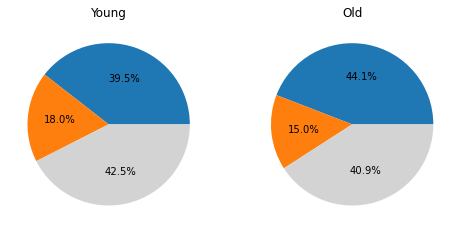

In [440]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
act_map = act_intermingling[act_intermingling['cell_state'] == 'young']
act_percent = act_map.groupby('activity')['activity'].count()
axs[0].pie(act_percent, autopct='%1.1f%%', colors = colors[1:])
axs[0].set_title('Young')
act_map = act_intermingling[act_intermingling['cell_state'] == 'old']
act_percent = act_map.groupby('activity')['activity'].count()
axs[1].pie(act_percent, autopct='%1.1f%%', colors = colors[1:])
axs[1].set_title('Old')
plt.show()

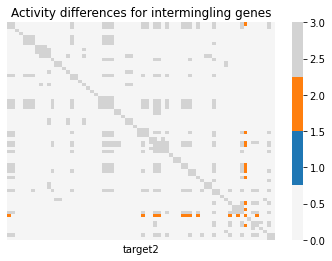

In [441]:
diff_act = 10 * act_map_y + act_map_o
diff_act = diff_act.replace([11, 22, 33, 12, 21, 13, 23, 31, 32], [3, 3, 3, 1, 2, 1, 0, 2, 0])

sns.heatmap(diff_act, cmap = cmap, xticklabels=False, yticklabels=False)
plt.ylabel('') 
plt.title('Activity differences for intermingling genes')
plt.show()

### Up- & Downregulation

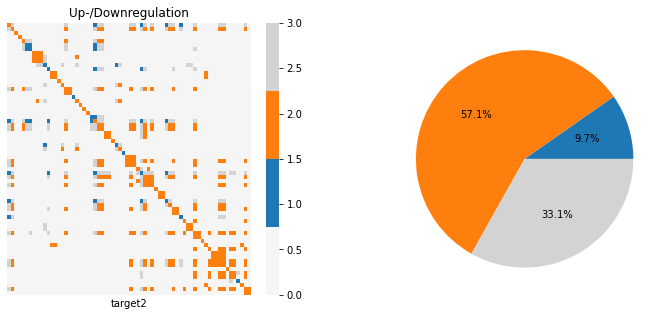

In [442]:
# load activities of DE genes
activities = pd.read_csv(save_dir+'DE_genes/DE_updown.csv')
activities = activities[['gene', 'transition', 'updown']]
activities = activities[activities['gene'].isin(TF_diff_map.columns)]

# add activities to diff map
act_intermingling = diff_map_long.merge(activities.rename(columns = {'gene': 'target1', 'updown': 'activity1'}))
act_intermingling = act_intermingling.merge(activities.rename(columns = {'gene': 'target2', 'updown': 'activity2'}))
act_intermingling['activity'] = act_intermingling['activity1'] + "_" + act_intermingling['activity2']
act_intermingling['activity'] = act_intermingling['activity'].replace(['up_up', 'up_down', 'down_up', 'down_down'], [1, 3, 3, 2])

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

gene_order = [gene for gene in gene_order if gene in act_intermingling['target1'].unique()]
act_map = act_intermingling.pivot_table(index='target1', columns='target2', values='activity').fillna(0)
act_map = act_map.loc[gene_order, gene_order]
sns.heatmap(act_map, cmap = cmap, xticklabels=False, yticklabels=False, ax = axs[0])
axs[0].set_ylabel('') 
axs[0].set_title('Up-/Downregulation')
act_percent = act_intermingling.groupby('activity')['activity'].count()
axs[1].pie(act_percent, autopct='%1.1f%%', colors = colors[1:])
axs[1].set_title('')
plt.show()

## b) Shared net TF

In [443]:
def get_gene_order(TF_targets, diff_map): 
    locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]
    TF_targets = TF_targets.set_index('locus', drop = False)
    TF_targets = TF_targets.loc[locus_order, :]
    gene_order = TF_targets['target']
    return(gene_order)

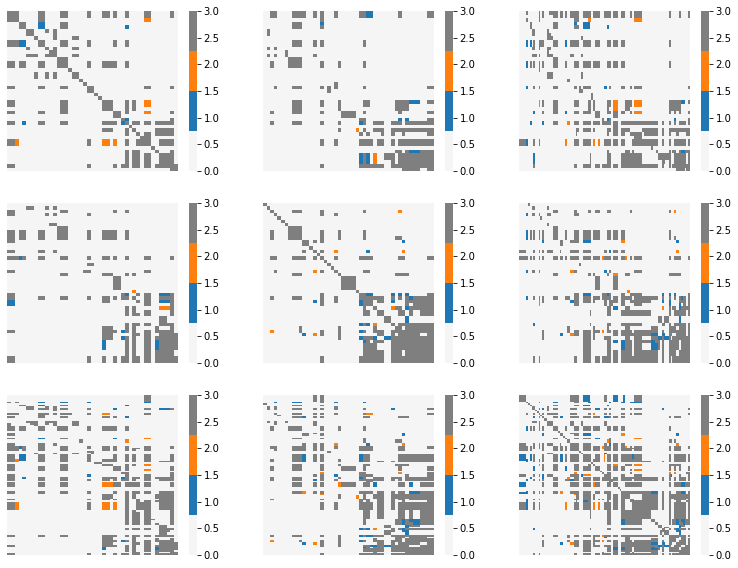

In [444]:
# Settings
TF = 'NOTCH1'
net1 = 'fc_16-26_27-60'
net2 = 'fc_27-60_61-85'
net3 = 'fc_61-85_86-96'
palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[0], palette[1], palette[7]]
cmap = ListedColormap(colors)

# load DE genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')

# load targets of selected TF
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
TF_targets = TF_targets[['target', 'locus']]

fig, axs = plt.subplots(3, 3, figsize = (13, 10))
axl = [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1], axs[1,2], axs[2,0], axs[2,1], axs[2,2]]
counter = 0
for pair in itertools.product([net1, net2, net3],[net1, net2, net3]):
    tr1, tr2 = pair
    # DE targets of networks
    TF_targets1 = TF_targets[TF_targets['target'].isin(DE_genes[DE_genes['transition'] == tr1]['gene'])]
    TF_targets2 = TF_targets[TF_targets['target'].isin(DE_genes[DE_genes['transition'] == tr2]['gene'])]

    # save order of the genes according the corresponding loci
    gene_order1 = get_gene_order(TF_targets1, diff_map)
    gene_order2 = get_gene_order(TF_targets2, diff_map)

    # create diff_map for DE targets
    diff_map_long = diff_map.copy()
    diff_map_long['loc1'] = diff_map_long.index
    diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
    diff_map_long = diff_map_long[diff_map_long['loc1'].isin(TF_targets1['locus']) & diff_map_long['loc2'].isin(TF_targets2['locus'])]
    diff_map_long = TF_targets1.rename(columns={"target": "target1", "locus": "loc1"}).merge(diff_map_long, on = 'loc1')
    diff_map_long = TF_targets2.rename(columns={"target": "target2", "locus": "loc2"}).merge(diff_map_long, on = 'loc2')
    diff_map_long = diff_map_long[['target1', 'target2', 'value']]
    TF_diff_map = diff_map_long.pivot_table(index='target1', columns='target2', values='value')

    # sorting according to chromosomes
    TF_diff_map = TF_diff_map.loc[gene_order1, gene_order2]
    
    # plot heatmap
    sns.heatmap(TF_diff_map, cmap = cmap, xticklabels=False, yticklabels=False, ax = axl[counter])
    axl[counter].set_xlabel('') 
    axl[counter].set_ylabel('') 
    #axl[counter].set_title('Intermingling differences')
    counter += 1
    
plt.show()

### Comparison between TF groups

In [312]:
# load DE genes and TF groups
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')

percentages_all_TFs = pd.DataFrame({'intermingling': [], 'percent': [], 'TF': [], 'net': []})
for transition in ['fc_16-26_27-60', 'fc_27-60_61-85', 'fc_61-85_86-96']:
    DE_genes_sub = DE_genes[DE_genes['transition'] == transition]
    if transition == 'fc_16-26_27-60': 
        net = 'young_net'
    elif transition == 'fc_27-60_61-85':
        net = 'middle_net'
    else: 
        net = 'old_net'
    print(net)
    TF_list = TF_groups.loc[TF_groups['net'] == net, 'TF']
    for TF in TF_list:
        # load DE targets of selected TF
        TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
        TF_targets = TF_targets[TF_targets['TF'] == TF]
        TF_targets = TF_targets[TF_targets['target'].isin(DE_genes_sub['gene'])]
        # skip TFs with less than 5 DE targets
        if TF_targets.shape[0] < 5:
            continue
        TF_targets = TF_targets[['target', 'locus']]

        # create diff_map for DE targets
        diff_map_long = diff_map.copy()
        diff_map_long['loc1'] = diff_map_long.index
        diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
        
        diff_map_long = diff_map_long[diff_map_long['loc1'].isin(TF_targets['locus']) & diff_map_long['loc2'].isin(TF_targets['locus'])]
        #diff_map_long = diff_map_long[diff_map_long['loc1'].isin(TF_targets['locus'])]
        
        diff_map_long = TF_targets.rename(columns={"target": "target1", "locus": "loc1"}).merge(diff_map_long, on = 'loc1')
        diff_map_long = TF_targets.rename(columns={"target": "target2", "locus": "loc2"}).merge(diff_map_long, on = 'loc2')
        
        diff_map_long = diff_map_long[['target1', 'target2', 'value']]
        #diff_map_long = diff_map_long[['target1', 'loc2', 'value']]
        
        diff_map_long = diff_map_long[diff_map_long['value'] != 0]
        
        # intermingling percentages
        intermingling_percent = diff_map_long.groupby('value')['value'].count()
        intermingling_percent = pd.DataFrame({'intermingling': intermingling_percent.index,
                                              'percent': intermingling_percent / np.sum(intermingling_percent), 
                                              'TF': TF, 
                                              'net': net})
        percentages_all_TFs = pd.concat([percentages_all_TFs, intermingling_percent], ignore_index = True)

young_net
middle_net
old_net


<Figure size 432x288 with 0 Axes>

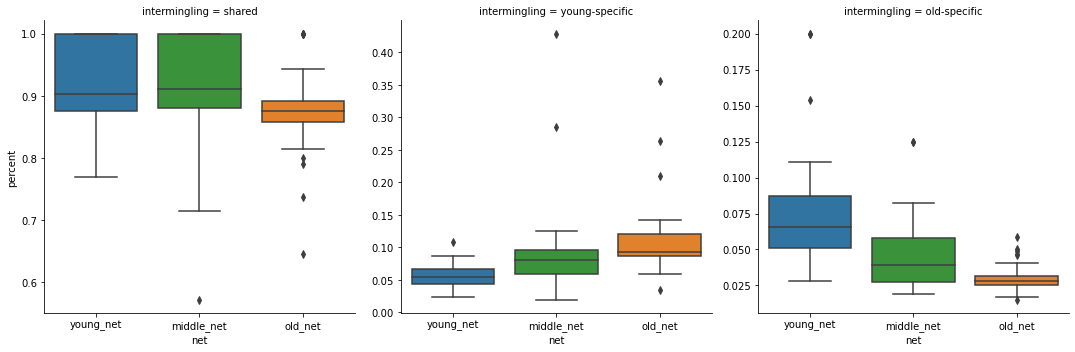

In [453]:
percentages_all_TFs = percentages_all_TFs[percentages_all_TFs['intermingling'] != 0]
percentages_all_TFs['intermingling'] = percentages_all_TFs['intermingling'].replace([1,2,3], ['young-specific', 'old-specific', 'shared'])

plt.figure()
sns.catplot(
    data=percentages_all_TFs, x='net', y='percent',
    col='intermingling', kind='box', col_wrap=4, sharey= False, palette = [palette[0], palette[2], palette[1]]
) 
plt.show()

# Connectivity plot

In [127]:
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TFs = TF_groups['TF'].unique()
TF_pairs = list(itertools.combinations(TFs, 2))
shared_targets = pd.DataFrame({'TF1': [], 'TF2': [], 'percent_shared': []})

for TF_pair in tqdm(TF_pairs):
    time.sleep(0.01)
    TF1, TF2 = TF_pair
    targets_TF1 = TF_targets[TF_targets['TF'] == TF1]
    targets_TF2 = TF_targets[TF_targets['TF'] == TF2]
    shared = set(targets_TF1['target']).intersection(set(targets_TF2['target']))
    percent = len(shared) / len(set(targets_TF1['target']).union(set(targets_TF2['target'])))
    rows = pd.DataFrame({'TF1': [TF1, TF2], 'TF2': [TF2, TF1], 'percent_shared': [percent, percent]})
    shared_targets = pd.concat([shared_targets, rows], ignore_index = True)

shared_targets.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5460/5460 [08:32<00:00, 10.65it/s]


,TF1,TF2,percent_shared
0,PML,SMAD3,0.112236
1,SMAD3,PML,0.112236
2,PML,SIN3A,0.098888
3,SIN3A,PML,0.098888
4,PML,FLI1,0.047328


In [159]:
TF_colors = pd.DataFrame({'TF': TFs, 'net': 'shared'})
young_TFs = set(TF_groups.loc[TF_groups['net'] == 'young_net', 'TF'])
middle_TFs = set(TF_groups.loc[TF_groups['net'] == 'middle_net', 'TF'])
old_TFs = set(TF_groups.loc[TF_groups['net'] == 'old_net', 'TF'])

TF_colors.loc[TF_colors['TF'].isin(young_TFs.difference(middle_TFs.union(old_TFs))), 'net'] = 'young_net'
TF_colors.loc[TF_colors['TF'].isin(middle_TFs.difference(young_TFs.union(old_TFs))), 'net'] = 'middle_net'
TF_colors.loc[TF_colors['TF'].isin(old_TFs.difference(young_TFs.union(middle_TFs))), 'net'] = 'old_net'
TF_colors['color'] = TF_colors['net'].replace(['shared', 'young_net', 'middle_net', 'old_net'], ['silver', 'blue', 'green', 'orange'])
TF_colors = TF_colors.sort_values(by=['color'])

TF_colors.head()

,TF,net,color
12,CTNNB1,young_net,blue
48,RELA,young_net,blue
49,GLI2,young_net,blue
21,ZKSCAN1,young_net,blue
50,EP300,young_net,blue


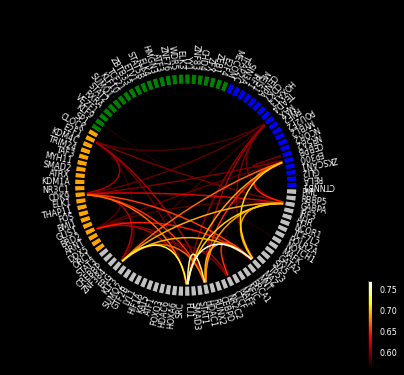

In [152]:
shared_targets_wide = pd.pivot_table(shared_targets, columns = 'TF2', index = 'TF1', fill_value = 0, values = 'percent_shared')
shared_targets_wide = shared_targets_wide.loc[TF_colors['TF'], TF_colors['TF']]
color_list = [TF_colors.loc[TF_colors['TF'] == TF, 'color'].values[0] for TF in list(shared_targets_wide.index)]
plot_connectivity_circle(np.array(shared_targets_wide), list(shared_targets_wide.index), 
                         n_lines = 50, node_colors = color_list)
plt.show()

## Number of DE targets per TF

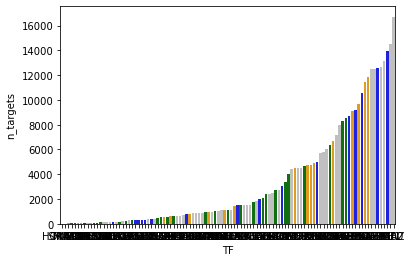

In [189]:
# All targets
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
n_targets = TF_targets.groupby('TF')['TF'].count().to_frame(name = 'n_targets')
n_targets = n_targets.reset_index()
n_targets = TF_colors.merge(n_targets)
n_targets = n_targets.sort_values(by=['n_targets'])
colors = n_targets['color'].to_list()

sns.barplot(data=n_targets, x="TF", y="n_targets", palette = colors)
plt.show()

<AxesSubplot:xlabel='net', ylabel='n_targets'>

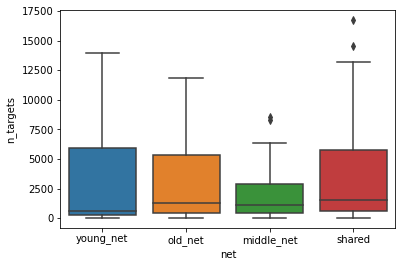

In [187]:
sns.boxplot(data = n_targets, x = "net", y = "n_targets")

In [200]:
# Only DE targets
n_DE_targets = pd.DataFrame({'TF': [], 'net': [], 'n': []})
for net in ['young_net', 'middle_net', 'old_net', 'shared']:
    if net == 'young_net': 
        transition = ['fc_16-26_27-60']
    elif net == 'middle_net':
        transition = ['fc_27-60_61-85']
    elif net == 'old_net':
        transition = ['fc_61-85_86-96']
    else: 
        transition = ['fc_16-26_27-60', 'fc_27-60_61-85', 'fc_61-85_86-96']
    DE_genes_sub = DE_genes[DE_genes['transition'].isin(transition)]
    TF_list = TF_colors.loc[TF_colors['net'] == net, 'TF']
    
    for TF in TF_list:
        # load DE targets of selected TF
        TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
        TF_targets = TF_targets[TF_targets['TF'] == TF]
        TF_targets = TF_targets[TF_targets['target'].isin(DE_genes_sub['gene'])]
        DE_targets = TF_targets.shape[0]
        if net == 'shared':
            DE_targets = DE_targets / 3 #average over the three networks
        n_DE_targets = pd.concat([n_DE_targets, pd.DataFrame({'TF': [TF], 'net': [net], 'n': [DE_targets]})], ignore_index = True)

n_DE_targets = n_DE_targets.merge(TF_colors)
n_DE_targets = n_DE_targets.sort_values(by=['n'])
colors = n_DE_targets['color'].to_list()

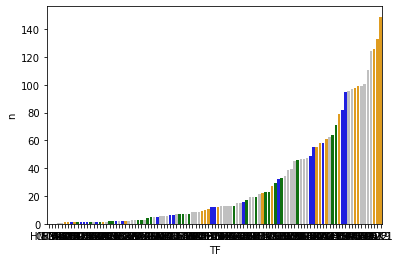

In [201]:
sns.barplot(data=n_DE_targets, x="TF", y="n", palette = colors)
plt.show()

<AxesSubplot:xlabel='net', ylabel='n'>

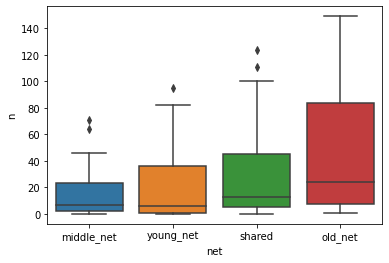

In [317]:
sns.boxplot(data = n_DE_targets, x = "net", y = "n")

# Diff map for all young and old DE targets

(142, 2)


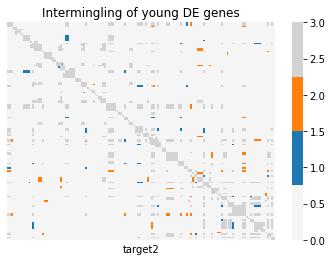

In [805]:
transition = 'fc_16-26_27-60'

# load DE genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]

# load loci of all DE targets
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[['target', 'locus']].drop_duplicates()
print(TF_targets.shape)

# save order of the genes according the corresponding loci
locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]
TF_targets = TF_targets.set_index('locus', drop = False)
TF_targets = TF_targets.loc[locus_order, :]
gene_order = TF_targets['target']

# create diff_map for DE targets
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(TF_targets['locus']) & diff_map_long['loc2'].isin(TF_targets['locus'])]
diff_map_long = TF_targets.rename(columns={"target": "target1", "locus": "loc1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = TF_targets.rename(columns={"target": "target2", "locus": "loc2"}).merge(diff_map_long, on = 'loc2')
diff_map_long = diff_map_long[['target1', 'target2', 'value']]
TF_diff_map = diff_map_long.pivot_table(index='target1', columns='target2', values='value')

# sorting according to chromosomes
TF_diff_map = TF_diff_map.loc[gene_order, gene_order]

young_genes = TF_diff_map.columns[(TF_diff_map==1).any(axis=1)].tolist()

palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[0], palette[1], 'lightgrey']
cmap = ListedColormap(colors)

sns.heatmap(TF_diff_map, cmap = cmap, xticklabels=False, yticklabels=False)
plt.ylabel('') 
plt.title('Intermingling of young DE genes')
plt.show()

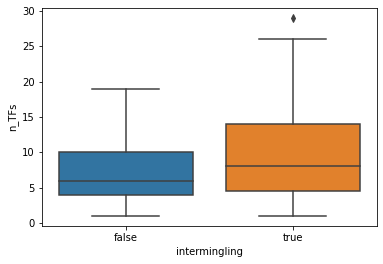

In [806]:
# by how many TFs is each gene targeted?
intermingling_genes = TF_diff_map.columns[(TF_diff_map.isin([1, 2])).any(axis=1)].tolist()

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TF_groups.loc[TF_groups['net'].isin(['young_net', 'shared']), 'TF'])]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'false'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'true'

plt.figure()
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs') 
plt.show()

<AxesSubplot:xlabel='target2'>

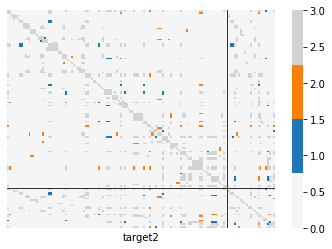

In [807]:
diff.diff_map_updown(TF_diff_map, gene_order, transition, save_dir + 'DE_genes/')

In [775]:
# save diff map for all upregulated young DE genes
# Load differentially expressed genes
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]
DE_genes = DE_genes[DE_genes['updown'] == "up"]
diff_map_up = TF_diff_map.loc[TF_diff_map.columns.isin(DE_genes['gene']), TF_diff_map.columns.isin(DE_genes['gene'])]
diff_map_up.to_csv(save_dir + 'processed_hic_data/difference_maps/diff_DE_up_young.csv', index = False)


In [731]:
young_diff = diff_map_long[diff_map_long['value'] == 1]
results = pd.DataFrame({'counts': [], 'TF': [], 'group': [], 'n_targets': []})

for ix in tqdm(range(TF_colors.shape[0])):
    time.sleep(0.01)
    TF = TF_colors.iloc[ix, 0]
    group = TF_colors.iloc[ix, 1]
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_results = pd.DataFrame({'target1': young_diff['target1'],
                             'target2': young_diff['target2'],
                             'TF_target1': young_diff['target1'].isin(TF_targets['target']), 
                             'TF_target2': young_diff['target2'].isin(TF_targets['target']),
                             'n_targets': 1})
    TF_results.iloc[(TF_results['TF_target1'] == True) & (TF_results['TF_target2'] == True), 4] = 2
    TF_results.iloc[(TF_results['TF_target1'] == False) & (TF_results['TF_target2'] == False), 4] = 0
    TF_results = pd.DataFrame({"counts": TF_results.groupby('n_targets')['n_targets'].count()})
    TF_results['TF'] = TF
    TF_results['group'] = group
    TF_results['n_targets'] = TF_results.index
    results = pd.concat([results, TF_results])

print(results.head())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [01:14<00:00,  1.40it/s]

   counts      TF      group  n_targets
0   468.0  CTNNB1  young_net        0.0
0   418.0    RELA  young_net        0.0
1    48.0    RELA  young_net        1.0
2     2.0    RELA  young_net        2.0
0   426.0    GLI2  young_net        0.0


<Figure size 432x288 with 0 Axes>

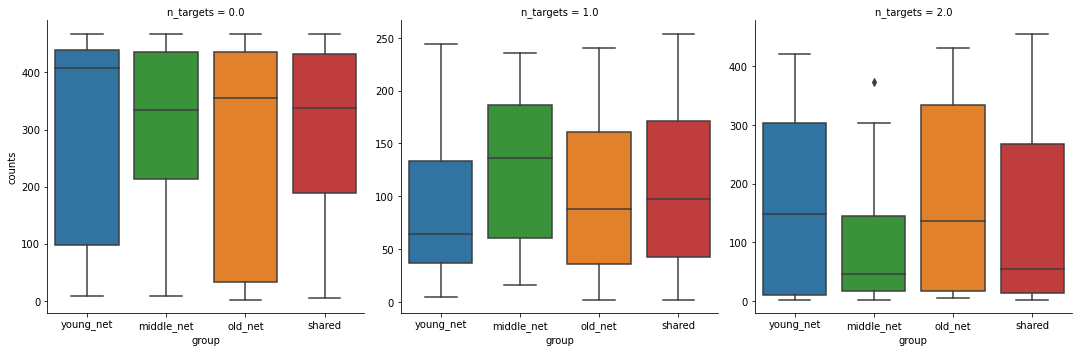

In [732]:
plt.figure()
sns.catplot(
    data=results, x='group', y='counts',
    col='n_targets', kind='box', col_wrap=4, sharey= False, palette = [palette[0], palette[2], palette[1], palette[3]]
) 
plt.show()

In [733]:
# GSEA
enr = gseapy.enrichr(gene_list=young_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', format='png',
                     verbose=False)

# Visualize results
barplot(enr.res2d, title=TF+ ' targets',
        cutoff=0.05, top_term=5, figsize=(5, 5), color='salmon')

2022-12-06 08:01:01,050 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


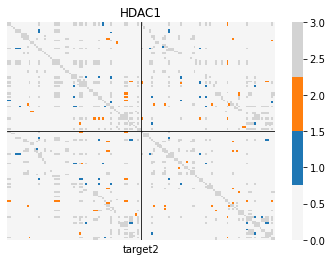

In [781]:
# sort TF targets to the beginning
TF = "HDAC1"

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]

TF_order = [target for target in gene_order if target in list(TF_targets['target'])]
target_len = len(TF_order)
TF_order = TF_order + [target for target in gene_order if target not in TF_order]

sns.heatmap(TF_diff_map.loc[TF_order, TF_order], cmap = cmap, xticklabels=False, yticklabels=False)
# add lines defining the target region
plt.plot([target_len, target_len], [0, len(TF_order)], 'k-', lw = 0.8)
plt.plot([0, len(TF_order)], [target_len, target_len], 'k-', lw = 0.8)
plt.ylabel('') 
plt.title(TF)
plt.show()

In [702]:
TF_list = TF_groups.loc[TF_groups['net'] == 'young_net', 'TF']

spec_intermingling = pd.DataFrame({'TF': [], 'spec_intermingling': []})
for TF in TF_list:
    # load DE targets of selected TF
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_targets = TF_targets[TF_targets['target'].isin(gene_order)]
    TF_targets = pd.DataFrame({'gene': TF_targets['target'], 
                              'intermingling': 'targets'})
    if TF_targets.shape[0] == 0:
        continue
    
    # save non targets
    non_targets = pd.DataFrame({'gene': list(set(gene_order).difference(TF_targets['gene'])), 
                              'intermingling': 'non_targets'})

    TF_results = pd.DataFrame({'intermingling': [], 'percent': []})
    for df in [TF_targets, non_targets]: 
        gene_list = df['gene']
        TF_diff_long = TF_diff_map.loc[gene_list, gene_list]
        TF_diff_long['loc1'] = TF_diff_long.index
        TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
        TF_diff_long = TF_diff_long[TF_diff_long['value']!=0]
        intermingling_percent = pd.DataFrame({'intermingling': [df.iloc[0, 1]],
                                              'percent': [(TF_diff_long['value'].isin([1, 2])).sum() / TF_diff_long.shape[0]]})
        TF_results = pd.concat([TF_results, intermingling_percent], ignore_index = True)
    spec_intermingling = pd.concat([spec_intermingling, 
                                   pd.DataFrame({'TF': [TF], 
                                                'spec_intermingling': TF_results.loc[TF_results['intermingling'] == "targets", 'percent'].item() / TF_results.loc[TF_results['intermingling'] == "non_targets", 'percent'].item()})], 
                                   ignore_index = True)
     
spec_intermingling.to_csv(hic_dir + 'spec_intermingling_young.csv', index = False)    
    
print(spec_intermingling.head())

      TF  spec_intermingling
0    PML            0.000000
1  SMAD3            0.000000
2  SIN3A            1.282095
3   FLI1            0.952969
4    SRC            0.000000


(165, 2)


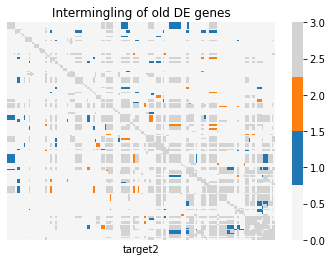

In [800]:
transition = 'fc_61-85_86-96'

# load DE genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]

# load loci of all DE targets
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[['target', 'locus']].drop_duplicates()
print(TF_targets.shape)

# save order of the genes according the corresponding loci
locus_order = [loc for loc in diff_map.columns if loc in TF_targets['locus'].unique()]
TF_targets = TF_targets.set_index('locus', drop = False)
TF_targets = TF_targets.loc[locus_order, :]
gene_order = TF_targets['target']

# create diff_map for DE targets
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(TF_targets['locus']) & diff_map_long['loc2'].isin(TF_targets['locus'])]
diff_map_long = TF_targets.rename(columns={"target": "target1", "locus": "loc1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = TF_targets.rename(columns={"target": "target2", "locus": "loc2"}).merge(diff_map_long, on = 'loc2')
diff_map_long = diff_map_long[['target1', 'target2', 'value']]
TF_diff_map = diff_map_long.pivot_table(index='target1', columns='target2', values='value')

# sorting according to chromosomes
TF_diff_map = TF_diff_map.loc[gene_order, gene_order]

old_genes = TF_diff_map.columns[(TF_diff_map==2).any(axis=1)].tolist()

#plt.figure(figsize = (10, 30))
sns.heatmap(TF_diff_map, cmap = cmap, xticklabels=False, yticklabels=False)
plt.ylabel('') 
plt.title('Intermingling of old DE genes')
plt.show()

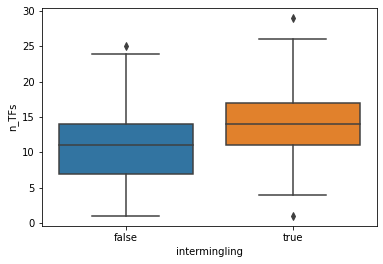

In [796]:
# by how many TFs is each gene targeted?
intermingling_genes = TF_diff_map.columns[(TF_diff_map.isin([1, 2])).any(axis=1)].tolist()

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TF_groups.loc[TF_groups['net'].isin(['young_net', 'shared']), 'TF'])]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'false'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'true'

plt.figure()
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs') 
plt.show()

<AxesSubplot:xlabel='target2'>

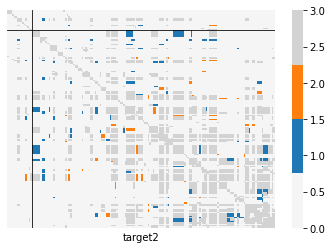

In [749]:
# seperate DE genes into up- and downreguluated ones
diff.diff_map_updown(TF_diff_map, gene_order, transition, save_dir + 'DE_genes/')

In [764]:
# save diff map for all downregulated old DE genes
# Load differentially expressed genes
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]
DE_genes = DE_genes[DE_genes['updown'] == "down"]
diff_map_down = TF_diff_map.loc[TF_diff_map.columns.isin(DE_genes['gene']), TF_diff_map.columns.isin(DE_genes['gene'])]
diff_map_down.to_csv(save_dir + 'processed_hic_data/difference_maps/diff_DE_down_old.csv', index = False)


In [746]:
old_diff = diff_map_long[diff_map_long['value'] == 2]
results = pd.DataFrame({'counts': [], 'TF': [], 'group': [], 'n_targets': []})

for ix in tqdm(range(TF_colors.shape[0])):
    time.sleep(0.01)
    TF = TF_colors.iloc[ix, 0]
    group = TF_colors.iloc[ix, 1]
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_results = pd.DataFrame({'target1': old_diff['target1'],
                             'target2': old_diff['target2'],
                             'TF_target1': old_diff['target1'].isin(TF_targets['target']), 
                             'TF_target2': old_diff['target2'].isin(TF_targets['target']),
                             'n_targets': 1})
    TF_results.iloc[(TF_results['TF_target1'] == True) & (TF_results['TF_target2'] == True), 4] = 2
    TF_results.iloc[(TF_results['TF_target1'] == False) & (TF_results['TF_target2'] == False), 4] = 0
    TF_results = pd.DataFrame({"counts": TF_results.groupby('n_targets')['n_targets'].count()})
    TF_results['TF'] = TF
    TF_results['group'] = group
    TF_results['n_targets'] = TF_results.index
    results = pd.concat([results, TF_results])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [01:14<00:00,  1.40it/s]


<Figure size 432x288 with 0 Axes>

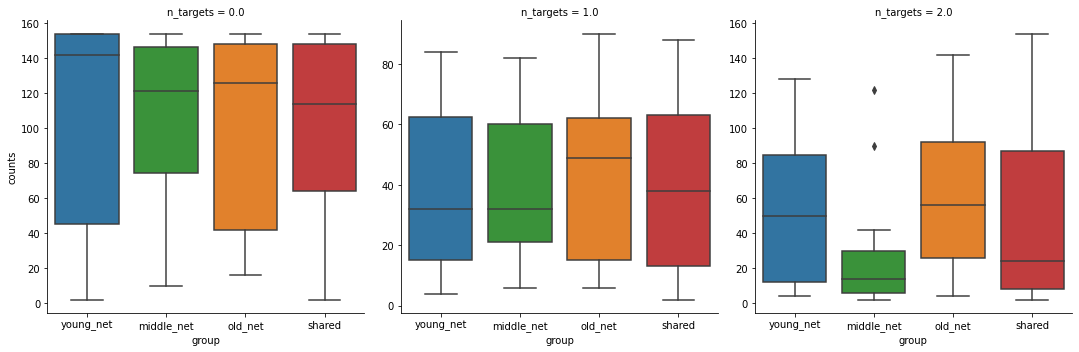

In [747]:
plt.figure()
sns.catplot(
    data=results, x='group', y='counts',
    col='n_targets', kind='box', col_wrap=4, sharey= False, palette = [palette[0], palette[2], palette[1], palette[3]]
) 
plt.show()

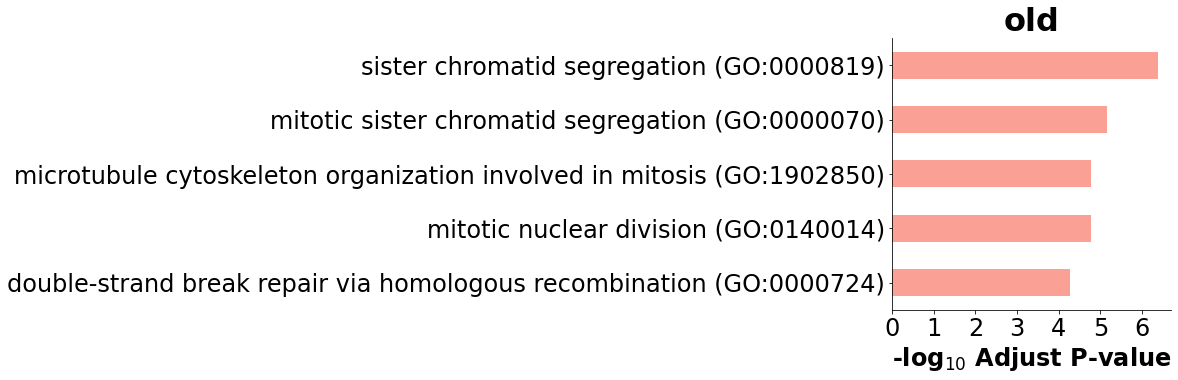

In [748]:
# GSEA
enr = gseapy.enrichr(gene_list=old_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', format='png',
                     verbose=False)

# Visualize results
barplot(enr.res2d, title='old',
        cutoff=0.05, top_term=5, figsize=(5, 5), color='salmon')

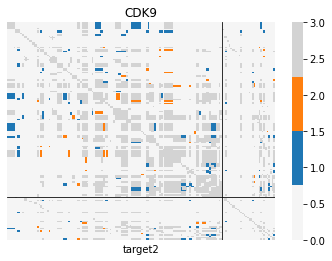

In [773]:
# sort TF targets to the beginning
TF = "CDK9"

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]

TF_order = [target for target in gene_order if target in list(TF_targets['target'])]
target_len = len(TF_order)
TF_order = TF_order + [target for target in gene_order if target not in TF_order]

sns.heatmap(TF_diff_map.loc[TF_order, TF_order], cmap = cmap, xticklabels=False, yticklabels=False)
# add lines defining the target region
plt.plot([target_len, target_len], [0, len(TF_order)], 'k-', lw = 0.8)
plt.plot([0, len(TF_order)], [target_len, target_len], 'k-', lw = 0.8)
plt.ylabel('') 
plt.title(TF)
plt.show()

In [729]:
TF_list = TF_groups.loc[TF_groups['net'] == 'old_net', 'TF']

spec_intermingling = pd.DataFrame({'TF': [], 'spec_intermingling': []})
for TF in TF_list:
    # load DE targets of selected TF
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_targets = TF_targets[TF_targets['target'].isin(gene_order)]
    TF_targets = pd.DataFrame({'gene': TF_targets['target'], 
                              'intermingling': 'targets'})
    if TF_targets.shape[0] == 0:
        continue
    
    # save non targets
    non_targets = pd.DataFrame({'gene': list(set(gene_order).difference(TF_targets['gene'])), 
                              'intermingling': 'non_targets'})

    TF_results = pd.DataFrame({'intermingling': [], 'percent': []})
    for df in [TF_targets, non_targets]: 
        gene_list = df['gene']
        TF_diff_long = TF_diff_map.loc[gene_list, gene_list]
        TF_diff_long['loc1'] = TF_diff_long.index
        TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
        TF_diff_long = TF_diff_long[TF_diff_long['value']!=0]
        intermingling_percent = pd.DataFrame({'intermingling': [df.iloc[0, 1]],
                                              'percent': [(TF_diff_long['value'].isin([1, 2])).sum() / TF_diff_long.shape[0]]})
        TF_results = pd.concat([TF_results, intermingling_percent], ignore_index = True)
        
    if TF_results.loc[TF_results['intermingling'] == "non_targets", 'percent'].item() == 0: 
        spec_intermingling = pd.concat([spec_intermingling, 
                                   pd.DataFrame({'TF': [TF], 
                                                'spec_intermingling': [10]})], 
                                   ignore_index = True)
    else: 
        spec_intermingling = pd.concat([spec_intermingling, 
                                       pd.DataFrame({'TF': [TF], 
                                                    'spec_intermingling': TF_results.loc[TF_results['intermingling'] == "targets", 'percent'].item() / TF_results.loc[TF_results['intermingling'] == "non_targets", 'percent'].item()})], 
                                       ignore_index = True)

        
spec_intermingling.to_csv(hic_dir + 'spec_intermingling_old.csv', index = False)    
    
print(spec_intermingling.head())

      TF  spec_intermingling
0    PML            0.000000
1  GLIS1            0.000000
2   FLI1           10.000000
3   SIX5            1.127227
4    SRC            0.975680


In [422]:
# percentages of targets that are DE and specific intermignling
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TFs = TF_targets['TF'].unique()

results = pd.DataFrame({'TF': [], 'total': [], 'young': [], 'old': []})

for TF in tqdm(TFs):
    time.sleep(0.01)
    targets = TF_targets[TF_targets['TF'] == TF]
    young = targets[targets['target'].isin(young_genes)]
    old = targets[targets['target'].isin(old_genes)]
    row = pd.DataFrame({'TF': [TF], 'total': [targets.shape[0]], 'young': [young.shape[0]], 'old': [old.shape[0]]})
    results = pd.concat([results, row], ignore_index = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:28<00:00, 17.14it/s]


In [423]:
results['young_percent'] = results['young'] / results['total']
results['old_percent'] = results['old'] / results['total']
results = results.sort_values(by = ['old_percent'], ascending = False)
results = results.merge(TF_colors, how = "left")
results['net'] = results['net'].fillna('no network')
results['color'] = results['color'].fillna('whitesmoke')
results = results[results['total'] > 30]
results.head()

,TF,total,young,old,young_percent,old_percent,net,color
11,WHSC1,50.0,0.0,3.0,0.000000,0.060000,no network,whitesmoke
13,HOXA4,172.0,0.0,9.0,0.000000,0.052326,no network,whitesmoke
15,BARX2,219.0,1.0,10.0,0.004566,0.045662,no network,whitesmoke
18,BTAF1,113.0,0.0,5.0,0.000000,0.044248,no network,whitesmoke
19,ATRX,49.0,0.0,2.0,0.000000,0.040816,old_net,orange


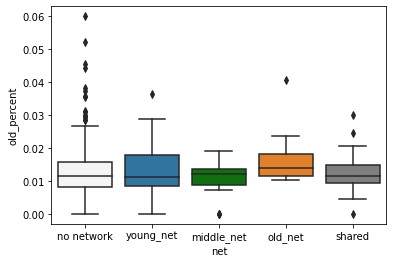

In [425]:
my_pal = {"no network": "whitesmoke", "young_net": palette[0], "middle_net": palette[2], "old_net": palette[1], "shared": palette[7]}
sns.boxplot(data = results, x = "net", y = "old_percent", palette = my_pal,
           order = ['no network', 'young_net', 'middle_net', 'old_net', 'shared'])
#plt.ylim([0,0.01])
plt.show()